In [29]:
# from numerov import find_eigen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import brentq

# import matplotlib.pyplot as plt

In [58]:
# def f(current, E):
#      return -2*(1/current+E)
    
def lennard_jones(current, E, l=0):
        
#     if current < 10:
    
#         V = 5.9*(( 1/current)**12 - 2*(1/current)**6)
#         # V = 0 if V >=0 else V
#     else:
#         V=0

    V = 5.9 * (( 3.57/current)**12 - 2*(3.57/current)**6)
    
    # if current < 1:
    #     V = -200
    # else:
    #     V = 0
    
    
    L = l * (l+1) * 3.57**2/ (6.12 * current**2)
    
    # print("V: ", V)
    # print("L: ", L)
    
    # if current < 0.8*3.57:
    # return 6.12 / current**12
    # else:
    return -6.12 / 3.57**2 *(-V - L + E)
    
    

In [59]:
map(lambda r:lennard_jones(r, 0), np.linspace(2, 15, 100))

In [60]:
3.15/3.57

0.8823529411764706

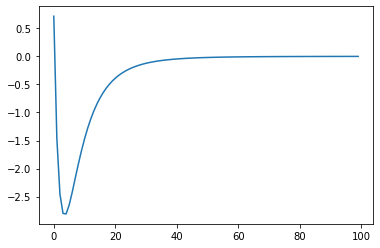

In [61]:
plt.plot(list(map(lambda r:lennard_jones(r, 0), np.linspace(3.15, 15, 100))))

In [62]:

def f(current, E):
    return -2*(1/current+E)

def w_aux(current, h, E, f):
    return 1 - h**2*f(current+h, E)/12

def dx_aux(current, h, E, f):
    return 1 - h**2*f(current+h, E)/6

def xh_aux(current, h, E, f):
    return 2+5*h**2*f(current, E)/6

def numerator(current, h, x_current, dx_current, E, f):
    return xh_aux(current, h, E, f) * w_aux(current, -h, E, f) * x_current + 2*h*dx_current*dx_aux(current, -h, E, f)

def denominator(current, h, x_current, dx_current, E, f):
    return w_aux(current, h, E, f) * dx_aux(current, -h, E, f) + w_aux(current, -h, E, f) * dx_aux(current, h, E, f)

def xh(current, h, x_current, dx_current, E, f):
    return numerator(current, h, x_current, dx_current, E, f) / denominator(current, h, x_current, dx_current, E, f)


def numerov_log(E, f, start=1e-20, end=200, x_current=0, dx_current=0.0007, direction=-1, n_steps=5000):
    # E = -0.1
    # current = 10
    # h = 0.00001
    # x_current = 0
    # dx_current = 0.0007

    # x_prev = xh(current, -h, x_current, dx_current)


    if direction not in [-1, 1]:
        raise Exception("Invalid direction")

    # n_steps = int(current / h)

    grids = np.logspace(np.log(start), np.log(end), n_steps+1, base=np.e)[:]
    # grids = np.linspace(1e-5, current, n_steps+2)[1:]

    r_values = np.zeros((n_steps, ), dtype=float)
    xh_values = np.zeros((n_steps, ), dtype=float)
    
    current = start if direction > 0 else end


    # for i in tqdm(range(n_steps), position=0, leave=True):
    for i in range(n_steps):

        h = grids[::direction][i+1] -  grids[::direction][i]
        # print("h: ", h)

        current = grids[::direction][i]

        x_next = xh(current, h, x_current, dx_current, E, f)

        x_next_leap_frog = xh(current, 0.75*h, x_current, dx_current, E, f)

        dx_current = (x_next - x_next_leap_frog)/(0.25*h)

        x_current = x_next
        # current = current + h * direction

        r_values[::direction][i] = current
        xh_values[::direction][i] = x_current

    # normalization_factor = np.sqrt((xh_values * xh_values).sum())

    # xh_values /= normalization_factor

    return r_values, xh_values*direction, xh_values[0], xh_values[-1]


def find_eigen(f, E_lower=-0.7, E_upper=-1e-5, n_levels=100, start=1e-20, end=200, x_current=0, dx_current=0.0007, direction=-1, n_steps=5000):

    if E_lower * E_upper > 0:
        energy_grids = np.sign(E_lower) * np.logspace(np.log(abs(E_lower)), np.log(abs(E_upper)), n_levels, base=np.e)
    else:
        energy_grids = np.linspace(E_lower, E_upper, n_levels)

    E_guessed = []
    xh_guessed = []
    E_last = E_lower
    
    find_root = lambda e: numerov_log(e, f, start=start, end=end, x_current=x_current, dx_current=dx_current, direction=direction, n_steps=n_steps)[2 if direction< 0 else 3]
    
    if direction < 0:
        _, _, u_last, _ = numerov_log(E_last, f, start=start, end=end, x_current=x_current, dx_current=dx_current, direction=direction, n_steps=n_steps)
    else:
        _, _, _, u_last = numerov_log(E_last, f, start=start, end=end, x_current=x_current, dx_current=dx_current, direction=direction, n_steps=n_steps)
    # for egs in tqdm(E_guess, position=0, leave=True):
    for egs in energy_grids:
        if direction < 0:
            rv, xhv, u_current, _ = numerov_log(egs, f, start=start, end=end, x_current=x_current, dx_current=dx_current, direction=direction, n_steps=n_steps)
        else:
            rv, xhv, _, u_current = numerov_log(egs, f, start=start, end=end, x_current=x_current, dx_current=dx_current, direction=direction, n_steps=n_steps)
            
        # print("egs: ", egs, "u_0: ", u0_current)

        if u_current * u_last < 0:
            print("guess range: ", E_last, egs)

            egs_ = brentq(find_root, E_last, egs)


            print("energy level: ", egs_)

            E_guessed.append(egs_)
            xh_guessed.append((rv, xhv))

        E_last = egs

        u_last = u_current

    return E_guessed, xh_guessed

In [63]:
import sympy as sp
from sympy import Derivative, Function, Symbol, diff, lambdify

In [64]:
C = Symbol("C")
r = Symbol("r")
# r = sp.symarray("r", 100)
u = Function("f")


In [65]:
near_atom_wf = sp.exp(-C*r**(-5))

In [66]:
near_atom_wf

exp(-C/r**5)

In [67]:
near_atom_wf = diff(near_atom_wf, r)

In [68]:
near_atom_wf

5*C*exp(-C/r**5)/r**6

In [69]:
r = np.linspace(0, 10, 100)[1:]
C = np.sqrt(5.9*6.12/25)

In [70]:
np.exp(-C*(0.8*3.57)**(-5))

0.9936952477209263

In [71]:
nav = np.exp(-C*r**(-5))

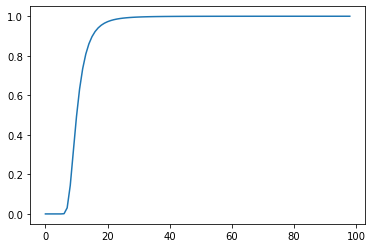

In [72]:
plt.plot(nav)

In [73]:
nav

array([0.00000000e+000, 0.00000000e+000, 5.48116970e-205, 3.37191911e-049,
       1.30814168e-016, 4.13846979e-007, 1.11362566e-003, 3.05665315e-002,
       1.44350812e-001, 3.18893349e-001, 4.91816261e-001, 6.31722352e-001,
       7.35050694e-001, 8.08556925e-001, 8.60273291e-001, 8.96734632e-001,
       9.22660513e-001, 9.41308220e-001, 9.54891819e-001, 9.64914695e-001,
       9.72403836e-001, 9.78067527e-001, 9.82399770e-001, 9.85749227e-001,
       9.88364936e-001, 9.90426873e-001, 9.92066580e-001, 9.93381245e-001,
       9.94443411e-001, 9.95307757e-001, 9.96015878e-001, 9.96599691e-001,
       9.97083889e-001, 9.97487726e-001, 9.97826323e-001, 9.98111640e-001,
       9.98353199e-001, 9.98558627e-001, 9.98734070e-001, 9.98884511e-001,
       9.99014006e-001, 9.99125879e-001, 9.99222865e-001, 9.99307222e-001,
       9.99380829e-001, 9.99445249e-001, 9.99501793e-001, 9.99551560e-001,
       9.99595481e-001, 9.99634339e-001, 9.99668804e-001, 9.99699444e-001,
       9.99726744e-001, 9

In [74]:
dnav = 5 * C * np.exp(-C/(r**5)) / r**6

In [75]:

5 * C * np.exp(-C/((0.8*3.57)**5)) / (0.5*3.57)**6

0.1845974115712031

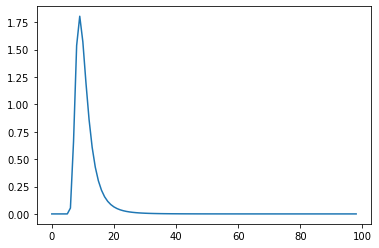

In [76]:
plt.plot(dnav)

In [77]:
dnav

array([0.00000000e+000, 0.00000000e+000, 4.25361917e-201, 4.65725571e-046,
       4.73639204e-014, 5.01816771e-005, 5.35505422e-002, 6.59658440e-001,
       1.53665743e+000, 1.80409061e+000, 1.57057853e+000, 1.19688287e+000,
       8.61529320e-001, 6.07512574e-001, 4.27269379e-001, 3.02382693e-001,
       2.16252577e-001, 1.56570416e-001, 1.14827379e-001, 8.52946578e-002,
       6.41421894e-002, 4.88029011e-002, 3.75434450e-002, 2.91817867e-002,
       2.29028834e-002, 1.81382428e-002, 1.44867551e-002, 1.16622045e-002,
       9.45812330e-003, 7.72400853e-003, 6.34905345e-003, 5.25090018e-003,
       4.36778190e-003, 3.65297704e-003, 3.07085687e-003, 2.59404198e-003,
       2.20133812e-003, 1.87622480e-003, 1.60573956e-003, 1.37964774e-003,
       1.18982015e-003, 1.02976316e-003, 8.94261460e-004, 7.79104749e-004,
       6.80877238e-004, 5.96794624e-004, 5.24577083e-004, 4.62349787e-004,
       4.08564556e-004, 3.61937869e-004, 3.21401550e-004, 2.86063385e-004,
       2.55175502e-004, 2

In [78]:
eigen_guessed, wave_function = find_eigen(
    lennard_jones, 
    E_lower=0, E_upper=10, n_levels=100, 
    start=0.5*3.57, end=30*3.57, 
    x_current=0.99, dx_current=0.18, 
    direction=1, n_steps=5000
)

guess range:  0.0 0.10101010101010101
energy level:  0.08951544926562428
guess range:  0.10101010101010101 0.20202020202020202
energy level:  0.18572664511459192
guess range:  0.5050505050505051 0.6060606060606061
energy level:  0.5451889655904179
guess range:  0.7070707070707071 0.8080808080808081
energy level:  0.7566235879447536
guess range:  0.8080808080808081 0.9090909090909091
energy level:  0.8347105816825655
guess range:  1.0101010101010102 1.1111111111111112
energy level:  1.091736213050986
guess range:  1.1111111111111112 1.2121212121212122
energy level:  1.184987049715934
guess range:  1.2121212121212122 1.3131313131313131
energy level:  1.2820201192518936
guess range:  1.3131313131313131 1.4141414141414141
energy level:  1.3828324705513646
guess range:  1.4141414141414141 1.5151515151515151
energy level:  1.4874213970418655
guess range:  1.5151515151515151 1.6161616161616161
energy level:  1.5957844231207792
guess range:  1.6161616161616161 1.7171717171717171
energy level: 

In [79]:
len(eigen_guessed)

54

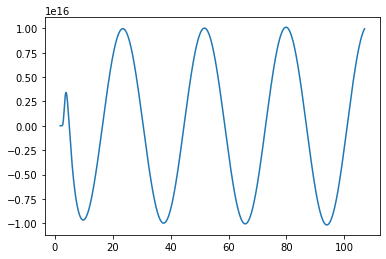

In [80]:
rv, xhv = wave_function[0]

plt.plot(rv[:], xhv[:])

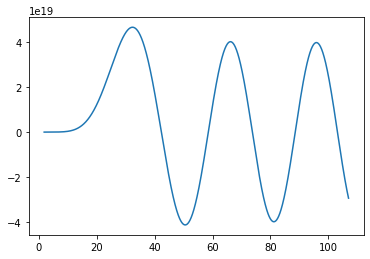

In [57]:
rv, xhv = wave_function[0]
plt.plot(rv[:], xhv[:])

In [400]:
rv

array([1.00000000e-03, 1.00209878e-03, 1.00420197e-03, ...,
       3.54761608e+01, 3.55506175e+01, 3.56252305e+01])